#Project Title : Multiclass Fish Image Classification

#Problem Statement

This project focuses on classifying fish images into multiple categories using deep learning models. The task involves training a CNN from scratch and leveraging transfer learning with pre-trained models to enhance performance. The project also includes saving models for later use and deploying a Streamlit application to predict fish categories from user-uploaded images.

#A) Initialising Project

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# After this, your Drive files will be available at:
# /content/drive/MyDrive/


Mounted at /content/drive


In [ ]:
dataset_path = "/content/drive/MyDrive/images.cv_jzk6llhf18tm3k0kyttxz/data"


#B) Importing all Libraries

In [ ]:
# Step 2: Importing Libraries

# ========== Basic Utilities ==========
import os        # For file and directory operations
import numpy as np  # For numerical operations
import pandas as pd  # For handling structured data

# ========== Visualization ==========
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns            # For beautiful statistical plots

# ========== Deep Learning (TensorFlow / Keras) ==========
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For loading & augmenting images
from tensorflow.keras.models import Sequential                       # For building CNN models from scratch
from tensorflow.keras.layers import (Conv2D, MaxPooling2D,
                                     Flatten, Dense, Dropout,
                                     BatchNormalization)              # CNN building blocks
from tensorflow.keras.applications import (VGG16, ResNet50, MobileNet,
                                           InceptionV3, EfficientNetB0) # Pre-trained models
from tensorflow.keras.optimizers import Adam                          # Optimizer for training
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint  # Training callbacks

# ========== Model Evaluation ==========
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import itertools  # For confusion matrix plotting

#C) Understanding the Data

1) Set dataset path

In [ ]:
# Set dataset root path in Google Drive
dataset_root = "/content/drive/MyDrive/data/images.cv_jzk6llhf18tm3k0kyttxz/data"

train_dir = os.path.join(dataset_root, 'train')
val_dir   = os.path.join(dataset_root, 'val')
test_dir  = os.path.join(dataset_root, 'test')

# Check if folders exist
print("Train directory exists:", os.path.isdir(train_dir))
print("Validation directory exists:", os.path.isdir(val_dir))
print("Test directory exists:", os.path.isdir(test_dir))

Train directory exists: True
Validation directory exists: True
Test directory exists: True


2)Function to count images in a directory

In [ ]:
def count_images_in_directory(directory):
    total = 0
    for root, dirs, files in os.walk(directory):
        total += len([f for f in files if f.lower().endswith(('.jpg','.jpeg','.png'))])
    return total

3) Count images in each split

In [ ]:
train_count = count_images_in_directory(train_dir)
val_count   = count_images_in_directory(val_dir)
test_count  = count_images_in_directory(test_dir)

print(f"\nNumber of training images: {train_count}")
print(f"Number of validation images: {val_count}")
print(f"Number of test images: {test_count}")


Number of training images: 6225
Number of validation images: 1092
Number of test images: 3187


4) List classes from training set

In [ ]:
classes = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
print(f"\nNumber of classes: {len(classes)}")
print("Class names:", classes)



Number of classes: 11
Class names: ['animal fish', 'animal fish bass', 'fish sea_food black_sea_sprat', 'fish sea_food gilt_head_bream', 'fish sea_food hourse_mackerel', 'fish sea_food red_mullet', 'fish sea_food red_sea_bream', 'fish sea_food sea_bass', 'fish sea_food shrimp', 'fish sea_food striped_red_mullet', 'fish sea_food trout']


5) Show sample image from each class

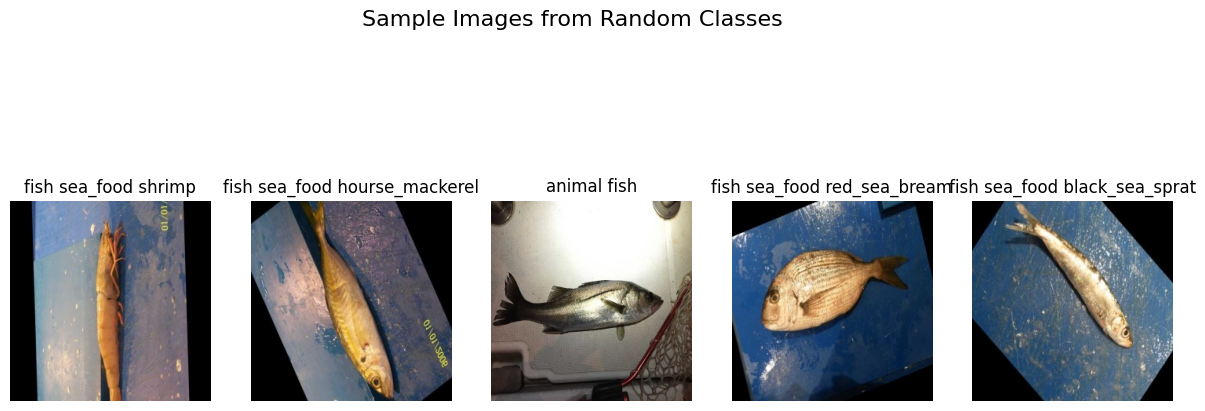

In [ ]:
import random
import matplotlib.image as mpimg

plt.figure(figsize=(15, 6))
for i, class_name in enumerate(random.sample(classes, min(5, len(classes)))):
    class_path = os.path.join(train_dir, class_name)
    img_file = random.choice([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg','.jpeg','.png'))])
    img_path = os.path.join(class_path, img_file)

    img = mpimg.imread(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.suptitle("Sample Images from Random Classes", fontsize=16)
plt.show()

#D) Basic EDA of Data

1) Helper function to count images per class

In [ ]:
def get_class_distribution(directory):
    class_counts = {}
    for class_name in sorted(os.listdir(directory)):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            class_counts[class_name] = count
    return class_counts

train_class_counts = get_class_distribution(train_dir)

2) Chart 1: Bar Plot - Number of images per class (Training Set)

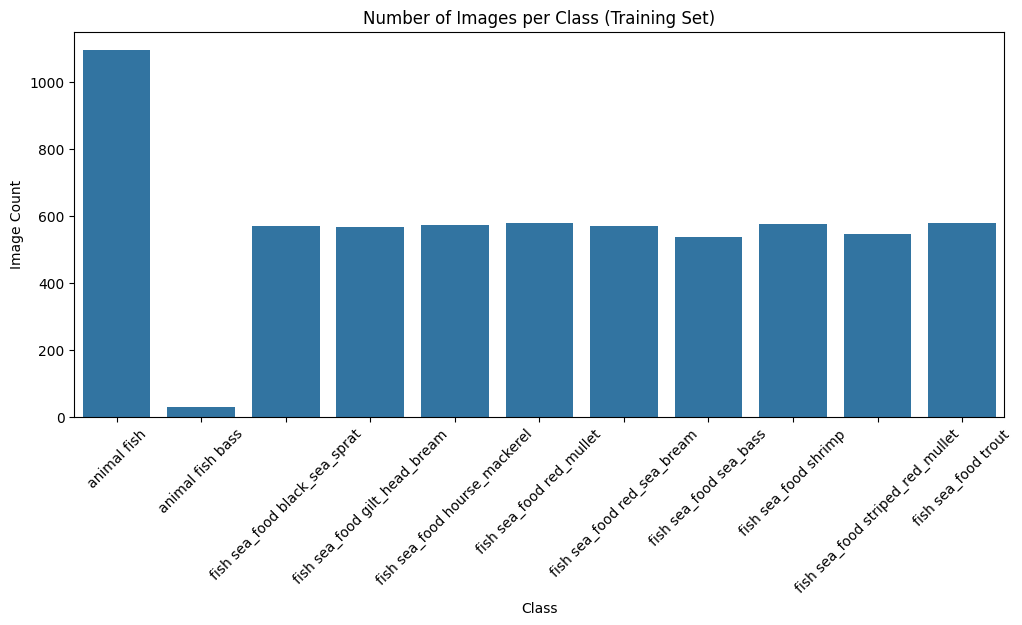

In [ ]:
plt.figure(figsize=(12, 5))
sns.barplot(x=list(train_class_counts.keys()), y=list(train_class_counts.values()))
plt.xticks(rotation=45)
plt.title("Number of Images per Class (Training Set)")
plt.ylabel("Image Count")
plt.xlabel("Class")
plt.show()


Chart Used: Bar Plot

Insights: Shows if classes are balanced or imbalanced in the training set.

In balanced datasets, each class should have a roughly equal number of images.


2) Chart 2: Pie Chart - Class Distribution Percentage

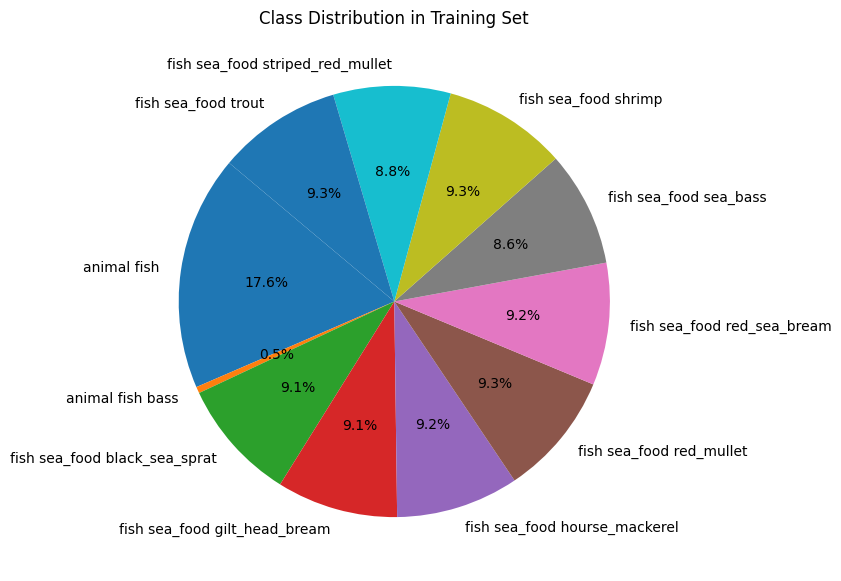

In [ ]:
plt.figure(figsize=(7, 7))
plt.pie(train_class_counts.values(), labels=train_class_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title("Class Distribution in Training Set")
plt.show()

Chart Used: Pie Chart

Insights: Gives percentage share of each class visually. Helps to quickly spot class imbalance.

3) Chart 3: Histogram - Image Width Distribution

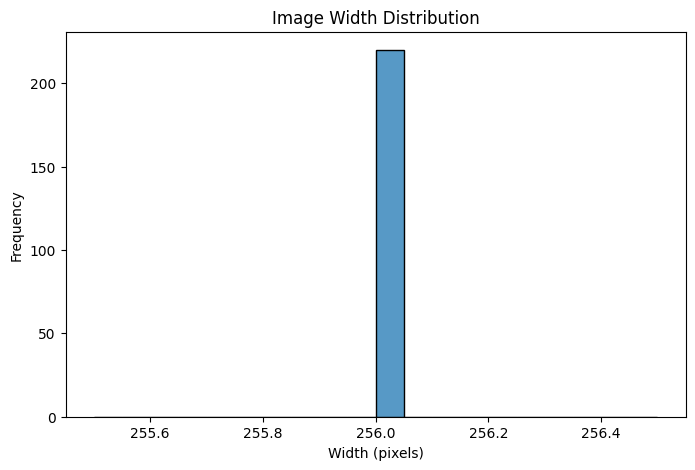

In [ ]:
image_widths = []
for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    sample_images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:20] # sample first 20
    for img_file in sample_images:
        img = mpimg.imread(os.path.join(class_path, img_file))
        image_widths.append(img.shape[1])

plt.figure(figsize=(8, 5))
sns.histplot(image_widths, bins=20, kde=False)
plt.title("Image Width Distribution")
plt.xlabel("Width (pixels)")
plt.ylabel("Frequency")
plt.show()

Chart Used: Histogram

Insights: Shows how varied the image widths are. Helps decide if resizing is necessary for model input.

4) Chart 4: Histogram - Image Height Distribution

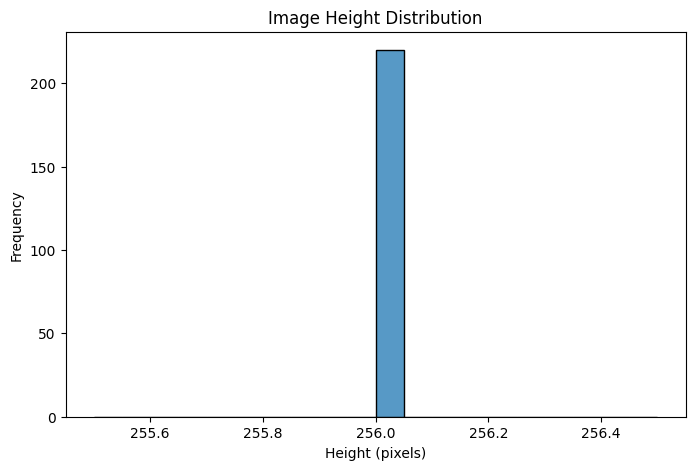

In [ ]:
image_heights = []
for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    sample_images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:20]
    for img_file in sample_images:
        img = mpimg.imread(os.path.join(class_path, img_file))
        image_heights.append(img.shape[0])

plt.figure(figsize=(8, 5))
sns.histplot(image_heights, bins=20, kde=False)
plt.title("Image Height Distribution")
plt.xlabel("Height (pixels)")
plt.ylabel("Frequency")
plt.show()

Chart Used: Histogram

Insights: Similar to width distribution, helps decide the target image size for models.

5) Chart 5: Image Grid - Sample Images from Multiple Classes

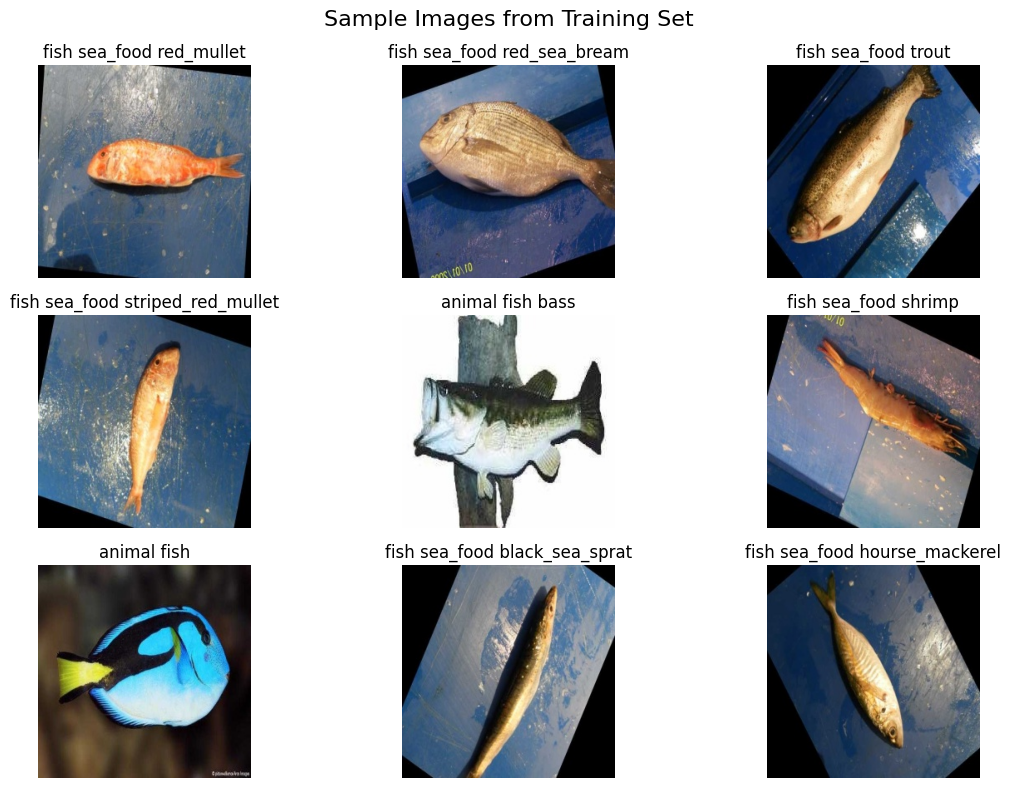

In [ ]:
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(random.sample(classes, min(9, len(classes)))):
    class_path = os.path.join(train_dir, class_name)
    img_file = random.choice([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    img_path = os.path.join(class_path, img_file)

    img = mpimg.imread(img_path)
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.suptitle("Sample Images from Training Set", fontsize=16)
plt.tight_layout()
plt.show()


Chart Used: Image Grid

Insights: Provides a quick visual check of image quality, color variety, and subject clarity.

#E) Data Preprocessing & Augmentation.

1) Image parameters

In [ ]:
img_height, img_width = 224, 224  # works well for most pretrained models
batch_size = 32

2) Data Augmentation for Training

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values
    rotation_range=20,          # Rotate images up to 20 degrees
    width_shift_range=0.1,      # Shift images horizontally by 10%
    height_shift_range=0.1,     # Shift images vertically by 10%
    zoom_range=0.2,             # Random zoom
    horizontal_flip=True        # Flip images horizontally
)

3) Only Rescaling for Validation and Test (no augmentation)

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

4) Create Generators

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.


5) Check Class Mapping

In [ ]:
print("Class Indices:", train_generator.class_indices)

Class Indices: {'animal fish': 0, 'animal fish bass': 1, 'fish sea_food black_sea_sprat': 2, 'fish sea_food gilt_head_bream': 3, 'fish sea_food hourse_mackerel': 4, 'fish sea_food red_mullet': 5, 'fish sea_food red_sea_bream': 6, 'fish sea_food sea_bass': 7, 'fish sea_food shrimp': 8, 'fish sea_food striped_red_mullet': 9, 'fish sea_food trout': 10}


Explanation
Rescaling – converts pixel values from [0,255] → [0,1] for faster convergence.

Augmentation – creates variations of training images (rotations, flips, shifts, zoom) to reduce overfitting and improve model generalization.

Validation/Test Generators – only rescaled, no augmentation, so evaluation is on real (unaltered) data.

Class Indices – dictionary mapping class names to numeric labels.

6) Checking the Data

Average images per class: 565.9090909090909
Standard deviation: 238.72346116184494

Class counts:
                               Class  Image_Count
0                        animal fish         1096
1                   animal fish bass           30
2      fish sea_food black_sea_sprat          569
3      fish sea_food gilt_head_bream          566
4      fish sea_food hourse_mackerel          573
5           fish sea_food red_mullet          579
6        fish sea_food red_sea_bream          571
7             fish sea_food sea_bass          538
8               fish sea_food shrimp          576
9   fish sea_food striped_red_mullet          547
10               fish sea_food trout          580


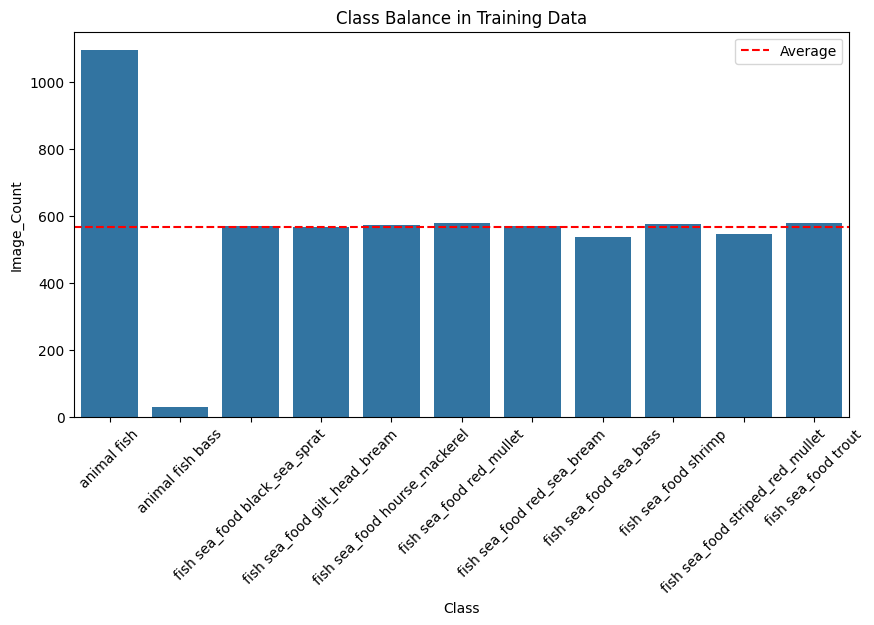

In [ ]:
# Check class balance
import pandas as pd

# Create DataFrame from training class counts
class_df = pd.DataFrame(list(train_class_counts.items()), columns=['Class', 'Image_Count'])

# Calculate statistics
mean_count = class_df['Image_Count'].mean()
std_dev = class_df['Image_Count'].std()

print("Average images per class:", mean_count)
print("Standard deviation:", std_dev)
print("\nClass counts:")
print(class_df)

# Quick visualization
plt.figure(figsize=(10,5))
sns.barplot(data=class_df, x='Class', y='Image_Count')
plt.xticks(rotation=45)
plt.axhline(mean_count, color='red', linestyle='--', label='Average')
plt.legend()
plt.title("Class Balance in Training Data")
plt.show()


If all bars are roughly similar in height and the standard deviation is small relative to the mean → Balanced dataset.

If some classes have significantly fewer or more images → Imbalanced dataset.

#F) Model Training

1) Define Model Architecture

In [ ]:
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')  # Output layer (multi-class)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2) Compile Model

In [ ]:
cnn_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

3) Set Callbacks

In [ ]:
# Define the directory for saving models
models_dir = '/content/drive/MyDrive/models'
os.makedirs(models_dir, exist_ok=True) # Create the directory if it doesn't exist

cnn_checkpoint_path = os.path.join(models_dir, 'cnn_from_scratch.h5')
cnn_checkpoint = ModelCheckpoint(cnn_checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

4. Train Model

In [ ]:
epochs = 25  # You can adjust this based on your dataset size and complexity

history = cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[cnn_checkpoint, early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2358 - loss: 2.1370
Epoch 1: val_accuracy improved from -inf to 0.48805, saving model to /content/drive/MyDrive/models/cnn_from_scratch.h5


194/194 ━━━━━━━━━━━━━━━━━━━━ 994s 5s/step - accuracy: 0.2362 - loss: 2.1360 - val_accuracy: 0.4881 - val_loss: 1.5717
Epoch 2/25
  1/194 ━━━━━━━━━━━━━━━━━━━━ 16:41 5s/step - accuracy: 0.3750 - loss: 1.8052

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.48805
194/194 ━━━━━━━━━━━━━━━━━━━━ 37s 166ms/step - accuracy: 0.3750 - loss: 1.8052 - val_accuracy: 0.4853 - val_loss: 1.5688
Epoch 3/25
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4378 - loss: 1.6327
Epoch 3: val_accuracy improved from 0.48805 to 0.66544, saving model to /content/drive/MyDrive/models/cnn_from_scratch.h5


194/194 ━━━━━━━━━━━━━━━━━━━━ 743s 4s/step - accuracy: 0.4380 - loss: 1.6323 - val_accuracy: 0.6654 - val_loss: 1.1817
Epoch 4/25
  1/194 ━━━━━━━━━━━━━━━━━━━━ 14:50 5s/step - accuracy: 0.5625 - loss: 1.3174
Epoch 4: val_accuracy improved from 0.66544 to 0.67279, saving model to /content/drive/MyDrive/models/cnn_from_scratch.h5


194/194 ━━━━━━━━━━━━━━━━━━━━ 42s 193ms/step - accuracy: 0.5625 - loss: 1.3174 - val_accuracy: 0.6728 - val_loss: 1.1755
Epoch 5/25
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5357 - loss: 1.3698
Epoch 5: val_accuracy improved from 0.67279 to 0.69301, saving model to /content/drive/MyDrive/models/cnn_from_scratch.h5


194/194 ━━━━━━━━━━━━━━━━━━━━ 749s 4s/step - accuracy: 0.5358 - loss: 1.3695 - val_accuracy: 0.6930 - val_loss: 0.9841
Epoch 6/25
  1/194 ━━━━━━━━━━━━━━━━━━━━ 8:41 3s/step - accuracy: 0.5938 - loss: 1.1402
Epoch 6: val_accuracy improved from 0.69301 to 0.70680, saving model to /content/drive/MyDrive/models/cnn_from_scratch.h5


194/194 ━━━━━━━━━━━━━━━━━━━━ 45s 219ms/step - accuracy: 0.5938 - loss: 1.1402 - val_accuracy: 0.7068 - val_loss: 0.9666
Epoch 7/25
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5889 - loss: 1.2188
Epoch 7: val_accuracy improved from 0.70680 to 0.77482, saving model to /content/drive/MyDrive/models/cnn_from_scratch.h5


194/194 ━━━━━━━━━━━━━━━━━━━━ 797s 4s/step - accuracy: 0.5890 - loss: 1.2186 - val_accuracy: 0.7748 - val_loss: 0.7946
Epoch 8/25
  1/194 ━━━━━━━━━━━━━━━━━━━━ 12:51 4s/step - accuracy: 0.6562 - loss: 1.0430
Epoch 8: val_accuracy improved from 0.77482 to 0.77665, saving model to /content/drive/MyDrive/models/cnn_from_scratch.h5


194/194 ━━━━━━━━━━━━━━━━━━━━ 47s 223ms/step - accuracy: 0.6562 - loss: 1.0430 - val_accuracy: 0.7767 - val_loss: 0.7782
Epoch 9/25
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6283 - loss: 1.1058
Epoch 9: val_accuracy did not improve from 0.77665
194/194 ━━━━━━━━━━━━━━━━━━━━ 794s 4s/step - accuracy: 0.6284 - loss: 1.1056 - val_accuracy: 0.7739 - val_loss: 0.7297
Epoch 10/25
  1/194 ━━━━━━━━━━━━━━━━━━━━ 8:59 3s/step - accuracy: 0.4375 - loss: 1.2975
Epoch 10: val_accuracy did not improve from 0.77665
194/194 ━━━━━━━━━━━━━━━━━━━━ 36s 174ms/step - accuracy: 0.4375 - loss: 1.2975 - val_accuracy: 0.7730 - val_loss: 0.7243
Epoch 11/25
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6566 - loss: 0.9912
Epoch 11: val_accuracy improved from 0.77665 to 0.82996, saving model to /content/drive/MyDrive/models/cnn_from_scratch.h5


194/194 ━━━━━━━━━━━━━━━━━━━━ 807s 4s/step - accuracy: 0.6567 - loss: 0.9912 - val_accuracy: 0.8300 - val_loss: 0.6312
Epoch 12/25
  1/194 ━━━━━━━━━━━━━━━━━━━━ 8:57 3s/step - accuracy: 0.5000 - loss: 1.2053
Epoch 12: val_accuracy improved from 0.82996 to 0.83548, saving model to /content/drive/MyDrive/models/cnn_from_scratch.h5


194/194 ━━━━━━━━━━━━━━━━━━━━ 78s 391ms/step - accuracy: 0.5000 - loss: 1.2053 - val_accuracy: 0.8355 - val_loss: 0.6248
Epoch 13/25
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6863 - loss: 0.8972
Epoch 13: val_accuracy improved from 0.83548 to 0.86121, saving model to /content/drive/MyDrive/models/cnn_from_scratch.h5


194/194 ━━━━━━━━━━━━━━━━━━━━ 743s 4s/step - accuracy: 0.6863 - loss: 0.8973 - val_accuracy: 0.8612 - val_loss: 0.5387
Epoch 14/25
  1/194 ━━━━━━━━━━━━━━━━━━━━ 12:31 4s/step - accuracy: 0.5938 - loss: 1.0439
Epoch 14: val_accuracy improved from 0.86121 to 0.86489, saving model to /content/drive/MyDrive/models/cnn_from_scratch.h5


194/194 ━━━━━━━━━━━━━━━━━━━━ 41s 195ms/step - accuracy: 0.5938 - loss: 1.0439 - val_accuracy: 0.8649 - val_loss: 0.5331
Epoch 15/25
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7056 - loss: 0.8694
Epoch 15: val_accuracy did not improve from 0.86489
194/194 ━━━━━━━━━━━━━━━━━━━━ 737s 4s/step - accuracy: 0.7056 - loss: 0.8693 - val_accuracy: 0.8474 - val_loss: 0.5042
Epoch 16/25
  1/194 ━━━━━━━━━━━━━━━━━━━━ 11:39 4s/step - accuracy: 0.8750 - loss: 0.4452
Epoch 16: val_accuracy did not improve from 0.86489
194/194 ━━━━━━━━━━━━━━━━━━━━ 40s 191ms/step - accuracy: 0.8750 - loss: 0.4452 - val_accuracy: 0.8474 - val_loss: 0.5075
Epoch 17/25
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7203 - loss: 0.8092
Epoch 17: val_accuracy improved from 0.86489 to 0.87316, saving model to /content/drive/MyDrive/models/cnn_from_scratch.h5


194/194 ━━━━━━━━━━━━━━━━━━━━ 734s 4s/step - accuracy: 0.7203 - loss: 0.8092 - val_accuracy: 0.8732 - val_loss: 0.4718
Epoch 18/25
  1/194 ━━━━━━━━━━━━━━━━━━━━ 9:01 3s/step - accuracy: 0.7188 - loss: 1.0560
Epoch 18: val_accuracy did not improve from 0.87316
194/194 ━━━━━━━━━━━━━━━━━━━━ 39s 189ms/step - accuracy: 0.7188 - loss: 1.0560 - val_accuracy: 0.8722 - val_loss: 0.4759
Epoch 19/25
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7418 - loss: 0.7514
Epoch 19: val_accuracy improved from 0.87316 to 0.89430, saving model to /content/drive/MyDrive/models/cnn_from_scratch.h5


194/194 ━━━━━━━━━━━━━━━━━━━━ 725s 4s/step - accuracy: 0.7418 - loss: 0.7514 - val_accuracy: 0.8943 - val_loss: 0.4235
Epoch 20/25
  1/194 ━━━━━━━━━━━━━━━━━━━━ 8:47 3s/step - accuracy: 0.7500 - loss: 0.8023
Epoch 20: val_accuracy did not improve from 0.89430
194/194 ━━━━━━━━━━━━━━━━━━━━ 39s 186ms/step - accuracy: 0.7500 - loss: 0.8023 - val_accuracy: 0.8860 - val_loss: 0.4280
Epoch 21/25
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7526 - loss: 0.7342
Epoch 21: val_accuracy improved from 0.89430 to 0.89982, saving model to /content/drive/MyDrive/models/cnn_from_scratch.h5


194/194 ━━━━━━━━━━━━━━━━━━━━ 804s 4s/step - accuracy: 0.7526 - loss: 0.7341 - val_accuracy: 0.8998 - val_loss: 0.3691
Epoch 22/25
  1/194 ━━━━━━━━━━━━━━━━━━━━ 8:48 3s/step - accuracy: 0.8125 - loss: 0.7452
Epoch 22: val_accuracy improved from 0.89982 to 0.90257, saving model to /content/drive/MyDrive/models/cnn_from_scratch.h5


194/194 ━━━━━━━━━━━━━━━━━━━━ 80s 399ms/step - accuracy: 0.8125 - loss: 0.7452 - val_accuracy: 0.9026 - val_loss: 0.3659
Epoch 23/25
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7745 - loss: 0.6606
Epoch 23: val_accuracy did not improve from 0.90257
194/194 ━━━━━━━━━━━━━━━━━━━━ 799s 4s/step - accuracy: 0.7745 - loss: 0.6606 - val_accuracy: 0.9007 - val_loss: 0.4091
Epoch 24/25
  1/194 ━━━━━━━━━━━━━━━━━━━━ 13:10 4s/step - accuracy: 0.8125 - loss: 0.5886
Epoch 24: val_accuracy did not improve from 0.90257
194/194 ━━━━━━━━━━━━━━━━━━━━ 40s 185ms/step - accuracy: 0.8125 - loss: 0.5886 - val_accuracy: 0.8989 - val_loss: 0.4044
Epoch 25/25
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7823 - loss: 0.6388
Epoch 25: val_accuracy improved from 0.90257 to 0.93382, saving model to /content/drive/MyDrive/models/cnn_from_scratch.h5


194/194 ━━━━━━━━━━━━━━━━━━━━ 805s 4s/step - accuracy: 0.7823 - loss: 0.6388 - val_accuracy: 0.9338 - val_loss: 0.3334


Explanation
Architecture — 3 convolution + pooling blocks to extract features, then dense layers for classification.

Activation — relu for hidden layers (non-linear mapping), softmax for multi-class output.

Optimizer — Adam with low learning rate (good for stable training).

Loss — categorical crossentropy for multi-class classification.

Callbacks —

ModelCheckpoint: saves best model based on validation accuracy.

EarlyStopping: stops training when validation loss stops improving.

5) Transfer Learning Pipeline

1) Pipeline

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet, InceptionV3, EfficientNetB0
from tensorflow.keras import layers, models

# ====== Step 1: Paths ======
# Folder to save models in Google Drive
models_dir = '/content/drive/MyDrive/models'
os.makedirs(models_dir, exist_ok=True)

# Copy dataset from Google Drive to Colab local storage for speed
#!cp -r "/content/drive/MyDrive/data/images.cv_jzk6llhf18tm3k0kyttxz/data" /content/data

# ====== Step 2: Parameters ======
img_height, img_width = 224, 224
batch_size = 64  # increased for speed
epochs = 3       # test run first

# ====== Step 3: Data Generators ======
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    "/content/data",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    "/content/data",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# ====== Step 4: Helper function to train & save model ======
def train_transfer_model(base_model_class, model_name):
    # Load base model
    base_model = base_model_class(weights='imagenet', include_top=False,
                                  input_shape=(img_height, img_width, 3))
    base_model.trainable = False  # freeze feature extractor

    # Build model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(train_generator.num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    checkpoint_path = os.path.join(models_dir, f"{model_name}.h5")
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[checkpoint, early_stop]
    )

    print(f"✅ {model_name} saved at: {checkpoint_path}")
    return history

# ====== Step 5: Train models ======
hist_vgg16   = train_transfer_model(VGG16, "VGG16_fish")


Found 9 images belonging to 1 classes.
Found 2 images belonging to 1 classes.


In [ ]:
hist_resnet  = train_transfer_model(ResNet50, "ResNet50_fish")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/3
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.5618 - loss: 0.9842
Epoch 1: val_accuracy improved from -inf to 0.59286, saving model to /content/drive/MyDrive/models/ResNet50_fish.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.5619 - loss: 0.9838 - val_accuracy: 0.5929 - val_loss: 0.9076
Epoch 2/3
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.5883 - loss: 0.9239
Epoch 2: val_accuracy did not improve from 0.59286
132/132 ━━━━━━━━━━━━━━━━━━━━ 127s 964ms/step - accuracy: 0.5883 - loss: 0.9238 - val_accuracy: 0.5929 - val_loss: 0.9082
Epoch 3/3
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.5909 - loss: 0.9201
Epoch 3: val_accuracy did not improve from 0.59286
132/132 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.5909 - loss: 0.9201 - val_accuracy: 0.5929 - val_loss: 0.9082
✅ ResNet50_fish saved at: /content/drive/MyDrive/models/ResNet50_fish.h5


In [ ]:
hist_mobile  = train_transfer_model(MobileNet, "MobileNet_fish")

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/3
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 767ms/step - accuracy: 0.5369 - loss: 1.1036
Epoch 1: val_accuracy improved from -inf to 0.59381, saving model to /content/drive/MyDrive/models/MobileNet_fish.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.5371 - loss: 1.1027 - val_accuracy: 0.5938 - val_loss: 0.9205
Epoch 2/3
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 742ms/step - accuracy: 0.6046 - loss: 0.9143
Epoch 2: val_accuracy did not improve from 0.59381
132/132 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.6045 - loss: 0.9143 - val_accuracy: 0.5929 - val_loss: 0.9241
Epoch 3/3
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.5860 - loss: 0.9307
Epoch 3: val_accuracy did not improve from 0.59381
132/132 ━━━━━━━━━━━━━━━━━━━━ 124s 943ms/step - accuracy: 0.5860 - loss: 0.9307 - val_accuracy: 0.5938 - val_loss: 0.9151
✅ MobileNet_fish saved at: /content/drive/MyDrive/models/MobileNet_fish.h5


In [ ]:
hist_incep   = train_transfer_model(InceptionV3, "InceptionV3_fish")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/3
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.5334 - loss: 1.1472
Epoch 1: val_accuracy improved from -inf to 0.59286, saving model to /content/drive/MyDrive/models/InceptionV3_fish.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.5337 - loss: 1.1461 - val_accuracy: 0.5929 - val_loss: 0.9179
Epoch 2/3
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 769ms/step - accuracy: 0.5866 - loss: 0.9367
Epoch 2: val_accuracy did not improve from 0.59286
132/132 ━━━━━━━━━━━━━━━━━━━━ 127s 962ms/step - accuracy: 0.5867 - loss: 0.9367 - val_accuracy: 0.5929 - val_loss: 0.9132
Epoch 3/3
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.5811 - loss: 0.9379
Epoch 3: val_accuracy did not improve from 0.59286
132/132 ━━━━━━━━━━━━━━━━━━━━ 126s 959ms/step - accuracy: 0.5812 - loss: 0.9378 - val_accuracy: 0.5929 - val_loss: 0.9154
✅ InceptionV3_fish saved at: /content/drive/MyDrive/models/InceptionV3_fish.h5


In [ ]:
hist_effnet  = train_transfer_model(EfficientNetB0, "EfficientNetB0_fish")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/3
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 829ms/step - accuracy: 0.5813 - loss: 0.9387
Epoch 1: val_accuracy improved from -inf to 0.59286, saving model to /content/drive/MyDrive/models/EfficientNetB0_fish.h5


132/132 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.5813 - loss: 0.9387 - val_accuracy: 0.5929 - val_loss: 0.9161
Epoch 2/3
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - accuracy: 0.5971 - loss: 0.9110
Epoch 2: val_accuracy did not improve from 0.59286
132/132 ━━━━━━━━━━━━━━━━━━━━ 165s 951ms/step - accuracy: 0.5971 - loss: 0.9110 - val_accuracy: 0.5929 - val_loss: 0.9107
Epoch 3/3
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 774ms/step - accuracy: 0.5865 - loss: 0.9240
Epoch 3: val_accuracy did not improve from 0.59286
132/132 ━━━━━━━━━━━━━━━━━━━━ 127s 966ms/step - accuracy: 0.5865 - loss: 0.9239 - val_accuracy: 0.5929 - val_loss: 0.9082
✅ EfficientNetB0_fish saved at: /content/drive/MyDrive/models/EfficientNetB0_fish.h5


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, InceptionV3, EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# === 1️⃣ Paths ===
drive_models_dir = '/content/drive/MyDrive/models'
os.makedirs(drive_models_dir, exist_ok=True)
# === 2️⃣ Image generators ===
img_height, img_width = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')
val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(img_height, img_width),
                                                batch_size=batch_size,
                                                class_mode='categorical')

# === 3️⃣ Helper function for building & training transfer learning models ===
def train_2phase_model(base_model, model_name):
    # --- Build Model ---
    base_model.trainable = False  # Phase 1: freeze base model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(train_generator.num_classes, activation='softmax')
    ])

    # Compile
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    save_path = os.path.join(drive_models_dir, f"{model_name}.h5")
    checkpoint = ModelCheckpoint(save_path, monitor='val_accuracy', save_best_only=True, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

    # --- Phase 1 Training ---
    print(f"\n🚀 Phase 1: Training {model_name} (frozen base)...")
    model.fit(train_generator,
              validation_data=val_generator,
              epochs=5,
              callbacks=[checkpoint, early_stop],
              verbose=1)

    # --- Phase 2: Fine-tuning ---
    print(f"\n🔧 Phase 2: Fine-tuning {model_name}...")
    base_model.trainable = True
    for layer in base_model.layers[:-4]:  # keep early layers frozen
        layer.trainable = False

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(train_generator,
              validation_data=val_generator,
              epochs=10,
              callbacks=[checkpoint, early_stop],
              verbose=1)

    print(f"✅ {model_name} saved at: {save_path}")
    return model

# === 4️⃣ Train all 5 models ===
models_to_train = [
    (VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)), "VGG16_fish"),
    (ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)), "ResNet50_fish"),
    (MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)), "MobileNetV2_fish"),
    (InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)), "InceptionV3_fish"),
    (EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)), "EfficientNetB0_fish"),
]

trained_models = {}
for base_model, name in models_to_train:
    trained_models[name] = train_2phase_model(base_model, name)

Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.

🚀 Phase 1: Training VGG16_fish (frozen base)...
Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.3536 - loss: 1.8947
Epoch 1: val_accuracy improved from -inf to 0.79212, saving model to /content/drive/MyDrive/models/VGG16_fish.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 121s 605ms/step - accuracy: 0.3544 - loss: 1.8930 - val_accuracy: 0.7921 - val_loss: 1.0038
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.7277 - loss: 0.9527
Epoch 2: val_accuracy improved from 0.79212 to 0.87546, saving model to /content/drive/MyDrive/models/VGG16_fish.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 108s 554ms/step - accuracy: 0.7278 - loss: 0.9522 - val_accuracy: 0.8755 - val_loss: 0.5992
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.8247 - loss: 0.6452
Epoch 3: val_accuracy improved from 0.87546 to 0.90293, saving model to /content/drive/MyDrive/models/VGG16_fish.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 107s 549ms/step - accuracy: 0.8247 - loss: 0.6450 - val_accuracy: 0.9029 - val_loss: 0.4430
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.8534 - loss: 0.4941
Epoch 4: val_accuracy improved from 0.90293 to 0.91026, saving model to /content/drive/MyDrive/models/VGG16_fish.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 112s 572ms/step - accuracy: 0.8534 - loss: 0.4940 - val_accuracy: 0.9103 - val_loss: 0.3496
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.8821 - loss: 0.4062
Epoch 5: val_accuracy improved from 0.91026 to 0.91758, saving model to /content/drive/MyDrive/models/VGG16_fish.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 109s 556ms/step - accuracy: 0.8821 - loss: 0.4061 - val_accuracy: 0.9176 - val_loss: 0.2881
Restoring model weights from the end of the best epoch: 5.

🔧 Phase 2: Fine-tuning VGG16_fish...
Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.9162 - loss: 0.2668
Epoch 1: val_accuracy improved from 0.91758 to 0.97253, saving model to /content/drive/MyDrive/models/VGG16_fish.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 130s 634ms/step - accuracy: 0.9163 - loss: 0.2666 - val_accuracy: 0.9725 - val_loss: 0.1181
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.9633 - loss: 0.1324
Epoch 2: val_accuracy improved from 0.97253 to 0.98626, saving model to /content/drive/MyDrive/models/VGG16_fish.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 114s 582ms/step - accuracy: 0.9633 - loss: 0.1323 - val_accuracy: 0.9863 - val_loss: 0.0688
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.9763 - loss: 0.0849
Epoch 3: val_accuracy did not improve from 0.98626
195/195 ━━━━━━━━━━━━━━━━━━━━ 114s 585ms/step - accuracy: 0.9763 - loss: 0.0849 - val_accuracy: 0.9817 - val_loss: 0.0677
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.9814 - loss: 0.0679
Epoch 4: val_accuracy improved from 0.98626 to 0.98901, saving model to /content/drive/MyDrive/models/VGG16_fish.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 108s 555ms/step - accuracy: 0.9814 - loss: 0.0679 - val_accuracy: 0.9890 - val_loss: 0.0494
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.9859 - loss: 0.0552
Epoch 5: val_accuracy did not improve from 0.98901
195/195 ━━━━━━━━━━━━━━━━━━━━ 108s 554ms/step - accuracy: 0.9859 - loss: 0.0552 - val_accuracy: 0.9881 - val_loss: 0.0423
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.9847 - loss: 0.0518
Epoch 6: val_accuracy improved from 0.98901 to 0.99084, saving model to /content/drive/MyDrive/models/VGG16_fish.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 109s 560ms/step - accuracy: 0.9847 - loss: 0.0518 - val_accuracy: 0.9908 - val_loss: 0.0363
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.9922 - loss: 0.0330
Epoch 7: val_accuracy improved from 0.99084 to 0.99176, saving model to /content/drive/MyDrive/models/VGG16_fish.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 119s 589ms/step - accuracy: 0.9922 - loss: 0.0330 - val_accuracy: 0.9918 - val_loss: 0.0310
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.9900 - loss: 0.0325
Epoch 8: val_accuracy did not improve from 0.99176
195/195 ━━━━━━━━━━━━━━━━━━━━ 108s 554ms/step - accuracy: 0.9900 - loss: 0.0325 - val_accuracy: 0.9918 - val_loss: 0.0353
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.9929 - loss: 0.0248
Epoch 9: val_accuracy did not improve from 0.99176
195/195 ━━━━━━━━━━━━━━━━━━━━ 106s 544ms/step - accuracy: 0.9929 - loss: 0.0248 - val_accuracy: 0.9908 - val_loss: 0.0293
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.9939 - loss: 0.0264
Epoch 10: val_accuracy improved from 0.99176 to 0.99451, saving model to /content/drive/MyDrive/models/VGG16_fish.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 111s 571ms/step - accuracy: 0.9939 - loss: 0.0264 - val_accuracy: 0.9945 - val_loss: 0.0241
Restoring model weights from the end of the best epoch: 10.
✅ VGG16_fish saved at: /content/drive/MyDrive/models/VGG16_fish.h5

🚀 Phase 1: Training ResNet50_fish (frozen base)...
Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.1580 - loss: 2.3519
Epoch 1: val_accuracy improved from -inf to 0.21978, saving model to /content/drive/MyDrive/models/ResNet50_fish.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 129s 585ms/step - accuracy: 0.1581 - loss: 2.3515 - val_accuracy: 0.2198 - val_loss: 2.1773
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.2057 - loss: 2.1869
Epoch 2: val_accuracy did not improve from 0.21978
195/195 ━━━━━━━━━━━━━━━━━━━━ 100s 511ms/step - accuracy: 0.2057 - loss: 2.1868 - val_accuracy: 0.1850 - val_loss: 2.1019
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.2237 - loss: 2.1142
Epoch 3: val_accuracy improved from 0.21978 to 0.32875, saving model to /content/drive/MyDrive/models/ResNet50_fish.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 102s 521ms/step - accuracy: 0.2237 - loss: 2.1141 - val_accuracy: 0.3288 - val_loss: 2.0299
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.2479 - loss: 2.0421
Epoch 4: val_accuracy did not improve from 0.32875
195/195 ━━━━━━━━━━━━━━━━━━━━ 100s 509ms/step - accuracy: 0.2479 - loss: 2.0421 - val_accuracy: 0.3095 - val_loss: 1.9747
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.2553 - loss: 2.0133
Epoch 5: val_accuracy improved from 0.32875 to 0.38004, saving model to /content/drive/MyDrive/models/ResNet50_fish.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 102s 522ms/step - accuracy: 0.2554 - loss: 2.0133 - val_accuracy: 0.3800 - val_loss: 1.9206
Restoring model weights from the end of the best epoch: 5.

🔧 Phase 2: Fine-tuning ResNet50_fish...
Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.1739 - loss: 6.3892
Epoch 1: val_accuracy did not improve from 0.38004
195/195 ━━━━━━━━━━━━━━━━━━━━ 124s 571ms/step - accuracy: 0.1740 - loss: 6.3778 - val_accuracy: 0.1740 - val_loss: 2.2672
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.2741 - loss: 2.0050
Epoch 2: val_accuracy did not improve from 0.38004
195/195 ━━━━━━━━━━━━━━━━━━━━ 99s 508ms/step - accuracy: 0.2741 - loss: 2.0049 - val_accuracy: 0.3086 - val_loss: 1.9199
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.2824 - loss: 1.9749
Epoch 3: val_accuracy improved from 0.38004 to 0.40018, saving model to /content/drive/MyDrive/models/ResNet50_fish.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 145s 525ms/step - accuracy: 0.2824 - loss: 1.9748 - val_accuracy: 0.4002 - val_loss: 1.8328
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.3050 - loss: 1.9341
Epoch 4: val_accuracy improved from 0.40018 to 0.42582, saving model to /content/drive/MyDrive/models/ResNet50_fish.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 141s 522ms/step - accuracy: 0.3051 - loss: 1.9341 - val_accuracy: 0.4258 - val_loss: 1.7997
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.3210 - loss: 1.9097
Epoch 5: val_accuracy did not improve from 0.42582
195/195 ━━━━━━━━━━━━━━━━━━━━ 102s 520ms/step - accuracy: 0.3210 - loss: 1.9097 - val_accuracy: 0.4240 - val_loss: 1.8032
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.3254 - loss: 1.8634
Epoch 6: val_accuracy improved from 0.42582 to 0.43407, saving model to /content/drive/MyDrive/models/ResNet50_fish.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 102s 522ms/step - accuracy: 0.3255 - loss: 1.8634 - val_accuracy: 0.4341 - val_loss: 1.7455
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.3347 - loss: 1.8450
Epoch 7: val_accuracy improved from 0.43407 to 0.45147, saving model to /content/drive/MyDrive/models/ResNet50_fish.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 102s 521ms/step - accuracy: 0.3347 - loss: 1.8450 - val_accuracy: 0.4515 - val_loss: 1.6984
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.3437 - loss: 1.8295
Epoch 8: val_accuracy improved from 0.45147 to 0.47161, saving model to /content/drive/MyDrive/models/ResNet50_fish.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 104s 531ms/step - accuracy: 0.3438 - loss: 1.8294 - val_accuracy: 0.4716 - val_loss: 1.6904
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.3609 - loss: 1.7974
Epoch 9: val_accuracy did not improve from 0.47161
195/195 ━━━━━━━━━━━━━━━━━━━━ 100s 515ms/step - accuracy: 0.3609 - loss: 1.7974 - val_accuracy: 0.4524 - val_loss: 1.6806
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.3493 - loss: 1.8046
Epoch 10: val_accuracy did not improve from 0.47161
195/195 ━━━━━━━━━━━━━━━━━━━━ 98s 505ms/step - accuracy: 0.3494 - loss: 1.8044 - val_accuracy: 0.4661 - val_loss: 1.6894
Restoring model weights from the end of the best epoch: 9.
✅ ResNet50_fish saved at: /content/drive/MyDrive/models/ResNet50_fish.h5

🚀 Phase 1: Training MobileNetV2_fish (frozen base)...
Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.7415 - loss: 0.8238
Epoch 1: val_accuracy improved from -inf to 0.97161, saving model to /content/drive/

195/195 ━━━━━━━━━━━━━━━━━━━━ 116s 546ms/step - accuracy: 0.7421 - loss: 0.8217 - val_accuracy: 0.9716 - val_loss: 0.0929
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.9602 - loss: 0.1160
Epoch 2: val_accuracy improved from 0.97161 to 0.97985, saving model to /content/drive/MyDrive/models/MobileNetV2_fish.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 97s 499ms/step - accuracy: 0.9602 - loss: 0.1160 - val_accuracy: 0.9799 - val_loss: 0.0614
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.9787 - loss: 0.0695
Epoch 3: val_accuracy did not improve from 0.97985
195/195 ━━━━━━━━━━━━━━━━━━━━ 94s 479ms/step - accuracy: 0.9787 - loss: 0.0695 - val_accuracy: 0.9789 - val_loss: 0.0642
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.9789 - loss: 0.0680
Epoch 4: val_accuracy did not improve from 0.97985
195/195 ━━━━━━━━━━━━━━━━━━━━ 95s 486ms/step - accuracy: 0.9789 - loss: 0.0679 - val_accuracy: 0.9762 - val_loss: 0.0671
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.9828 - loss: 0.0519
Epoch 5: val_accuracy improved from 0.97985 to 0.98168, saving model to /content/drive/MyDrive/models/MobileNetV2_fish.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 97s 495ms/step - accuracy: 0.9828 - loss: 0.0519 - val_accuracy: 0.9817 - val_loss: 0.0458
Restoring model weights from the end of the best epoch: 5.

🔧 Phase 2: Fine-tuning MobileNetV2_fish...
Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.7097 - loss: 1.1515
Epoch 1: val_accuracy did not improve from 0.98168
195/195 ━━━━━━━━━━━━━━━━━━━━ 115s 536ms/step - accuracy: 0.7102 - loss: 1.1493 - val_accuracy: 0.9670 - val_loss: 0.0981
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.9410 - loss: 0.1947
Epoch 2: val_accuracy did not improve from 0.98168
195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 491ms/step - accuracy: 0.9410 - loss: 0.1945 - val_accuracy: 0.9634 - val_loss: 0.1025
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.9635 - loss: 0.1054
Epoch 3: val_accuracy did not improve from 0.98168
195/195 ━━━━━━━━━━━━━━━━━━━━ 94s 481ms/step - accuracy: 0.9636 - loss: 0.1053 - val_accuracy: 0.9679 - val_loss: 0.0897

195/195 ━━━━━━━━━━━━━━━━━━━━ 97s 498ms/step - accuracy: 0.9824 - loss: 0.0521 - val_accuracy: 0.9863 - val_loss: 0.0478
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9844 - loss: 0.0477
Epoch 7: val_accuracy improved from 0.98626 to 0.98901, saving model to /content/drive/MyDrive/models/MobileNetV2_fish.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 492ms/step - accuracy: 0.9844 - loss: 0.0477 - val_accuracy: 0.9890 - val_loss: 0.0401
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.9848 - loss: 0.0466
Epoch 8: val_accuracy improved from 0.98901 to 0.99084, saving model to /content/drive/MyDrive/models/MobileNetV2_fish.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 97s 500ms/step - accuracy: 0.9848 - loss: 0.0466 - val_accuracy: 0.9908 - val_loss: 0.0370
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.9915 - loss: 0.0302
Epoch 9: val_accuracy did not improve from 0.99084
195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 494ms/step - accuracy: 0.9915 - loss: 0.0302 - val_accuracy: 0.9890 - val_loss: 0.0335
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.9897 - loss: 0.0330
Epoch 10: val_accuracy did not improve from 0.99084
195/195 ━━━━━━━━━━━━━━━━━━━━ 94s 482ms/step - accuracy: 0.9897 - loss: 0.0331 - val_accuracy: 0.9899 - val_loss: 0.0313
Restoring model weights from the end of the best epoch: 10.
✅ MobileNetV2_fish saved at: /content/drive/MyDrive/models/MobileNetV2_fish.h5

🚀 Phase 1: Training InceptionV3_fish (frozen base)...
Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.6343 - loss: 1.2393
Epoch 1: val_accuracy improved from -inf to 0.93956, saving model to /content/d

195/195 ━━━━━━━━━━━━━━━━━━━━ 139s 617ms/step - accuracy: 0.6351 - loss: 1.2365 - val_accuracy: 0.9396 - val_loss: 0.2224
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.9063 - loss: 0.2916
Epoch 2: val_accuracy improved from 0.93956 to 0.94597, saving model to /content/drive/MyDrive/models/InceptionV3_fish.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 103s 531ms/step - accuracy: 0.9063 - loss: 0.2915 - val_accuracy: 0.9460 - val_loss: 0.1534
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.9340 - loss: 0.2062
Epoch 3: val_accuracy improved from 0.94597 to 0.95696, saving model to /content/drive/MyDrive/models/InceptionV3_fish.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 103s 525ms/step - accuracy: 0.9340 - loss: 0.2062 - val_accuracy: 0.9570 - val_loss: 0.1255
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.9407 - loss: 0.1743
Epoch 4: val_accuracy improved from 0.95696 to 0.96429, saving model to /content/drive/MyDrive/models/InceptionV3_fish.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 140s 514ms/step - accuracy: 0.9407 - loss: 0.1742 - val_accuracy: 0.9643 - val_loss: 0.1014
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.9452 - loss: 0.1534
Epoch 5: val_accuracy improved from 0.96429 to 0.97436, saving model to /content/drive/MyDrive/models/InceptionV3_fish.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 102s 521ms/step - accuracy: 0.9452 - loss: 0.1534 - val_accuracy: 0.9744 - val_loss: 0.1083
Restoring model weights from the end of the best epoch: 4.

🔧 Phase 2: Fine-tuning InceptionV3_fish...
Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.9494 - loss: 0.1445
Epoch 1: val_accuracy did not improve from 0.97436
195/195 ━━━━━━━━━━━━━━━━━━━━ 130s 592ms/step - accuracy: 0.9494 - loss: 0.1444 - val_accuracy: 0.9744 - val_loss: 0.0806
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.9566 - loss: 0.1214
Epoch 2: val_accuracy did not improve from 0.97436
195/195 ━━━━━━━━━━━━━━━━━━━━ 98s 503ms/step - accuracy: 0.9566 - loss: 0.1214 - val_accuracy: 0.9734 - val_loss: 0.0762
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.9618 - loss: 0.1192
Epoch 3: val_accuracy did not improve from 0.97436
195/195 ━━━━━━━━━━━━━━━━━━━━ 100s 511ms/step - accuracy: 0.9618 - loss: 0.1192 - val_accuracy: 0.9734 - val_loss: 0.07

195/195 ━━━━━━━━━━━━━━━━━━━━ 99s 506ms/step - accuracy: 0.9634 - loss: 0.1049 - val_accuracy: 0.9780 - val_loss: 0.0721
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.9628 - loss: 0.1049
Epoch 6: val_accuracy did not improve from 0.97802
195/195 ━━━━━━━━━━━━━━━━━━━━ 101s 515ms/step - accuracy: 0.9628 - loss: 0.1049 - val_accuracy: 0.9780 - val_loss: 0.0717
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.9575 - loss: 0.1200
Epoch 7: val_accuracy did not improve from 0.97802
195/195 ━━━━━━━━━━━━━━━━━━━━ 99s 507ms/step - accuracy: 0.9575 - loss: 0.1199 - val_accuracy: 0.9762 - val_loss: 0.0726
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.9684 - loss: 0.0948
Epoch 8: val_accuracy improved from 0.97802 to 0.97985, saving model to /content/drive/MyDrive/models/InceptionV3_fish.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 102s 522ms/step - accuracy: 0.9684 - loss: 0.0948 - val_accuracy: 0.9799 - val_loss: 0.0706
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.9718 - loss: 0.0903
Epoch 9: val_accuracy did not improve from 0.97985
195/195 ━━━━━━━━━━━━━━━━━━━━ 98s 498ms/step - accuracy: 0.9718 - loss: 0.0903 - val_accuracy: 0.9789 - val_loss: 0.0715
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.9692 - loss: 0.0948
Epoch 10: val_accuracy did not improve from 0.97985
195/195 ━━━━━━━━━━━━━━━━━━━━ 143s 505ms/step - accuracy: 0.9692 - loss: 0.0948 - val_accuracy: 0.9799 - val_loss: 0.0686
Restoring model weights from the end of the best epoch: 10.
✅ InceptionV3_fish saved at: /content/drive/MyDrive/models/InceptionV3_fish.h5

🚀 Phase 1: Training EfficientNetB0_fish (frozen base)...
Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.1436 - loss: 2.3569
Epoch 1: val_accuracy improved from -inf to 0.17125, saving model to /cont

195/195 ━━━━━━━━━━━━━━━━━━━━ 140s 606ms/step - accuracy: 0.1437 - loss: 2.3567 - val_accuracy: 0.1712 - val_loss: 2.3181
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.1723 - loss: 2.3097
Epoch 2: val_accuracy did not improve from 0.17125
195/195 ━━━━━━━━━━━━━━━━━━━━ 96s 491ms/step - accuracy: 0.1723 - loss: 2.3097 - val_accuracy: 0.1712 - val_loss: 2.3161
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.1725 - loss: 2.3126
Epoch 3: val_accuracy did not improve from 0.17125
195/195 ━━━━━━━━━━━━━━━━━━━━ 95s 489ms/step - accuracy: 0.1725 - loss: 2.3126 - val_accuracy: 0.1712 - val_loss: 2.3135
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.1734 - loss: 2.3140
Epoch 4: val_accuracy did not improve from 0.17125
195/195 ━━━━━━━━━━━━━━━━━━━━ 93s 479ms/step - accuracy: 0.1734 - loss: 2.3139 - val_accuracy: 0.1712 - val_loss: 2.3110
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.1689 - loss: 2.3054
Epoch 5: val_accur

#G) Model Evaluation

1) Evaluation and Metrics

Found 1092 images belonging to 11 classes.

🔍 Evaluating CNN_from_scratch...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step
CNN_from_scratch → Accuracy: 0.9341, Precision: 0.9273, Recall: 0.9341, F1: 0.9296
                                  precision    recall  f1-score   support

                     animal fish       0.95      0.99      0.97       187
                animal fish bass       0.00      0.00      0.00        10
   fish sea_food black_sea_sprat       0.95      0.94      0.95       105
   fish sea_food gilt_head_bream       0.94      0.85      0.89        94
   fish sea_food hourse_mackerel       0.94      0.91      0.92        97
        fish sea_food red_mullet       0.97      1.00      0.98        90
     fish sea_food red_sea_bream       0.91      0.95      0.93       113
          fish sea_food sea_bass       0.84      0.92      0.88        97
            fish sea_food shrimp       1.00      0.96      0.98       100
fish sea_food striped_red_mullet       0.97      0.87      0.92       101
             fish sea_food trout       0.88      0.99      0.9

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


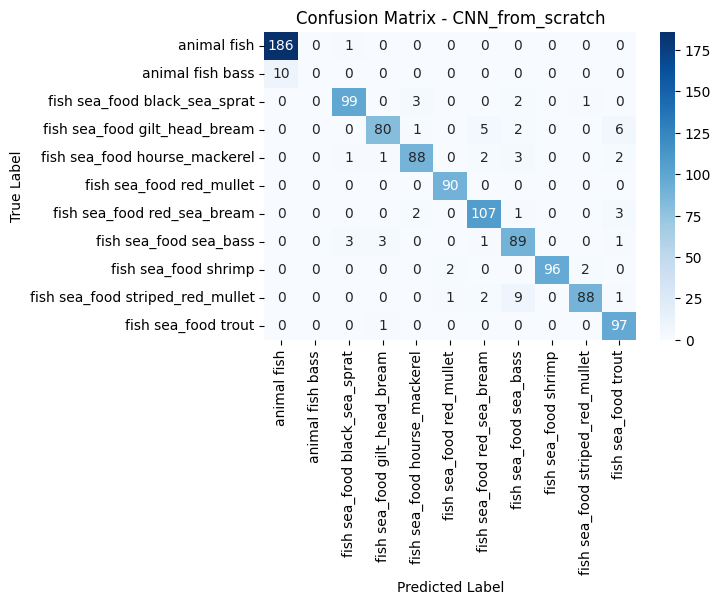


🔍 Evaluating VGG16_fish...


35/35 ━━━━━━━━━━━━━━━━━━━━ 699s 20s/step
VGG16_fish → Accuracy: 0.9945, Precision: 0.9946, Recall: 0.9945, F1: 0.9938
                                  precision    recall  f1-score   support

                     animal fish       0.97      0.99      0.98       187
                animal fish bass       1.00      0.50      0.67        10
   fish sea_food black_sea_sprat       1.00      1.00      1.00       105
   fish sea_food gilt_head_bream       1.00      1.00      1.00        94
   fish sea_food hourse_mackerel       1.00      1.00      1.00        97
        fish sea_food red_mullet       1.00      1.00      1.00        90
     fish sea_food red_sea_bream       1.00      1.00      1.00       113
          fish sea_food sea_bass       0.99      1.00      0.99        97
            fish sea_food shrimp       1.00      1.00      1.00       100
fish sea_food striped_red_mullet       1.00      1.00      1.00       101
             fish sea_food trout       1.00      1.00      1.00    

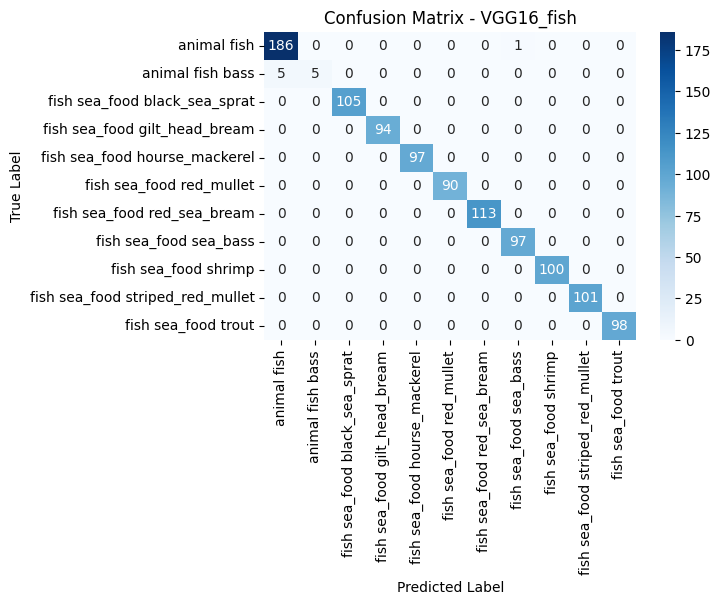


🔍 Evaluating ResNet50_fish...


35/35 ━━━━━━━━━━━━━━━━━━━━ 207s 6s/step
ResNet50_fish → Accuracy: 0.4716, Precision: 0.4792, Recall: 0.4716, F1: 0.4226
                                  precision    recall  f1-score   support

                     animal fish       0.63      0.76      0.69       187
                animal fish bass       0.00      0.00      0.00        10
   fish sea_food black_sea_sprat       0.48      0.28      0.35       105
   fish sea_food gilt_head_bream       0.50      0.01      0.02        94
   fish sea_food hourse_mackerel       0.33      0.79      0.47        97
        fish sea_food red_mullet       0.37      0.44      0.40        90
     fish sea_food red_sea_bream       0.65      0.55      0.59       113
          fish sea_food sea_bass       0.42      0.16      0.24        97
            fish sea_food shrimp       0.62      0.66      0.64       100
fish sea_food striped_red_mullet       0.29      0.05      0.08       101
             fish sea_food trout       0.37      0.79      0.50  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


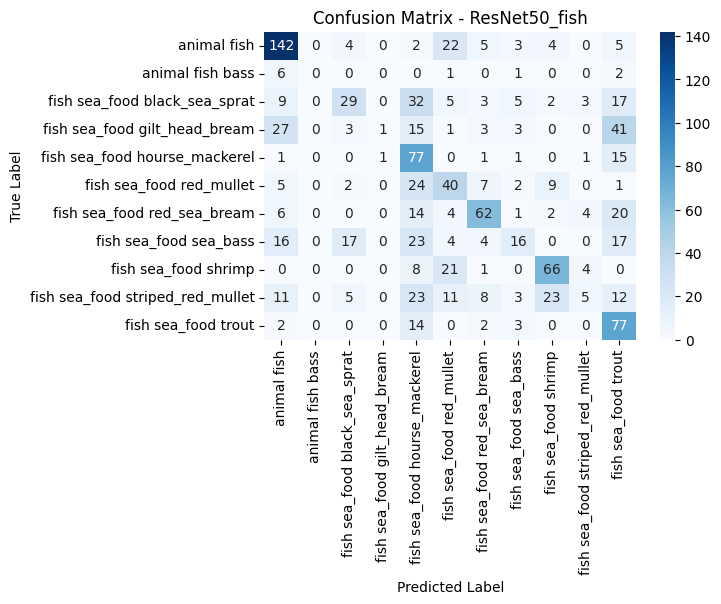


🔍 Evaluating MobileNetV2_fish...


35/35 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step
MobileNetV2_fish → Accuracy: 0.9908, Precision: 0.9910, Recall: 0.9908, F1: 0.9909
                                  precision    recall  f1-score   support

                     animal fish       1.00      0.97      0.99       187
                animal fish bass       1.00      1.00      1.00        10
   fish sea_food black_sea_sprat       1.00      0.98      0.99       105
   fish sea_food gilt_head_bream       0.99      1.00      0.99        94
   fish sea_food hourse_mackerel       1.00      0.99      0.99        97
        fish sea_food red_mullet       0.99      0.99      0.99        90
     fish sea_food red_sea_bream       1.00      1.00      1.00       113
          fish sea_food sea_bass       0.97      1.00      0.98        97
            fish sea_food shrimp       0.98      1.00      0.99       100
fish sea_food striped_red_mullet       0.97      0.99      0.98       101
             fish sea_food trout       1.00      1.00      1.00

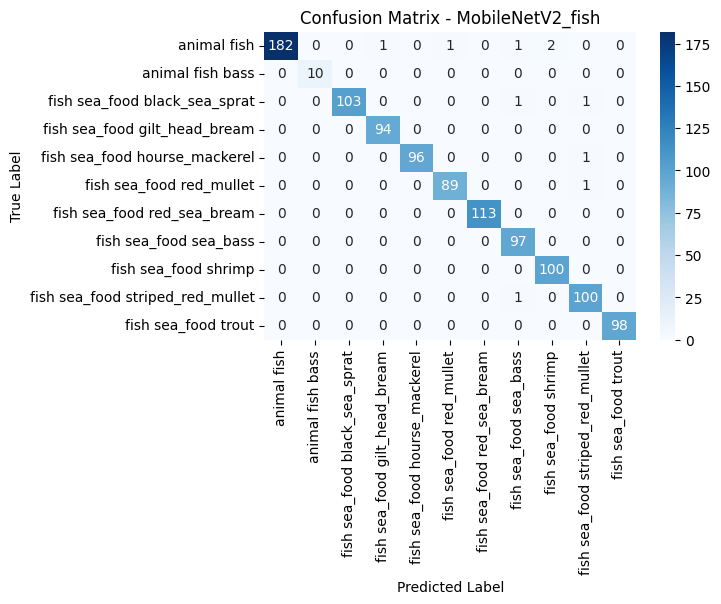


🔍 Evaluating InceptionV3_fish...


35/35 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step
InceptionV3_fish → Accuracy: 0.9799, Precision: 0.9804, Recall: 0.9799, F1: 0.9775
                                  precision    recall  f1-score   support

                     animal fish       0.95      0.99      0.97       187
                animal fish bass       1.00      0.20      0.33        10
   fish sea_food black_sea_sprat       1.00      0.96      0.98       105
   fish sea_food gilt_head_bream       0.98      0.99      0.98        94
   fish sea_food hourse_mackerel       0.97      0.99      0.98        97
        fish sea_food red_mullet       0.99      0.98      0.98        90
     fish sea_food red_sea_bream       1.00      0.98      0.99       113
          fish sea_food sea_bass       0.99      0.98      0.98        97
            fish sea_food shrimp       1.00      1.00      1.00       100
fish sea_food striped_red_mullet       0.96      1.00      0.98       101
             fish sea_food trout       0.98      0.99      0.9

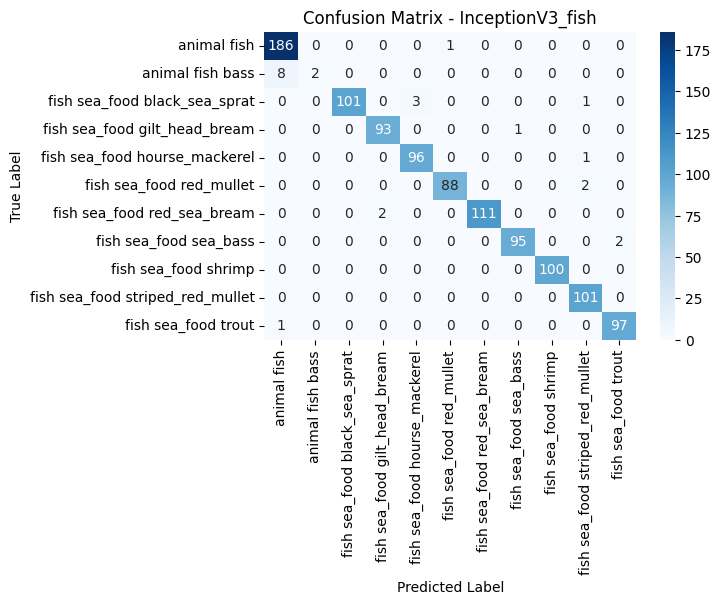


🔍 Evaluating EfficientNetB0_fish...


35/35 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step
EfficientNetB0_fish → Accuracy: 0.1712, Precision: 0.0293, Recall: 0.1712, F1: 0.0501
                                  precision    recall  f1-score   support

                     animal fish       0.17      1.00      0.29       187
                animal fish bass       0.00      0.00      0.00        10
   fish sea_food black_sea_sprat       0.00      0.00      0.00       105
   fish sea_food gilt_head_bream       0.00      0.00      0.00        94
   fish sea_food hourse_mackerel       0.00      0.00      0.00        97
        fish sea_food red_mullet       0.00      0.00      0.00        90
     fish sea_food red_sea_bream       0.00      0.00      0.00       113
          fish sea_food sea_bass       0.00      0.00      0.00        97
            fish sea_food shrimp       0.00      0.00      0.00       100
fish sea_food striped_red_mullet       0.00      0.00      0.00       101
             fish sea_food trout       0.00      0.00      0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


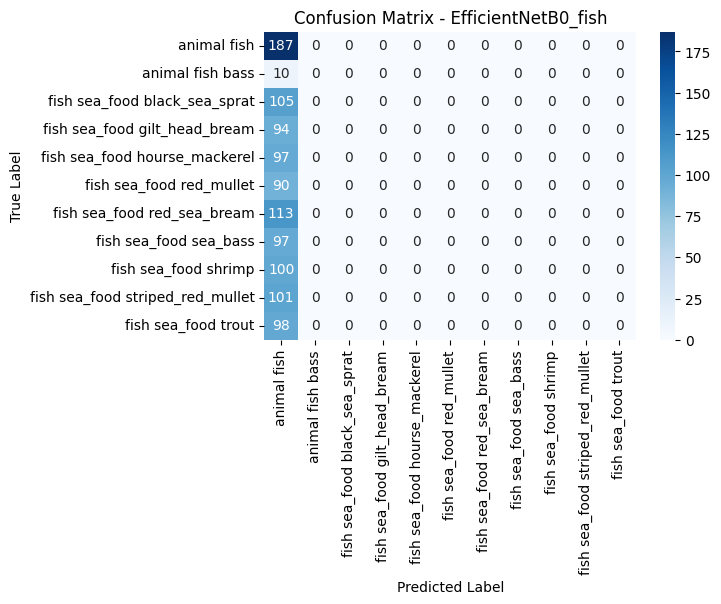

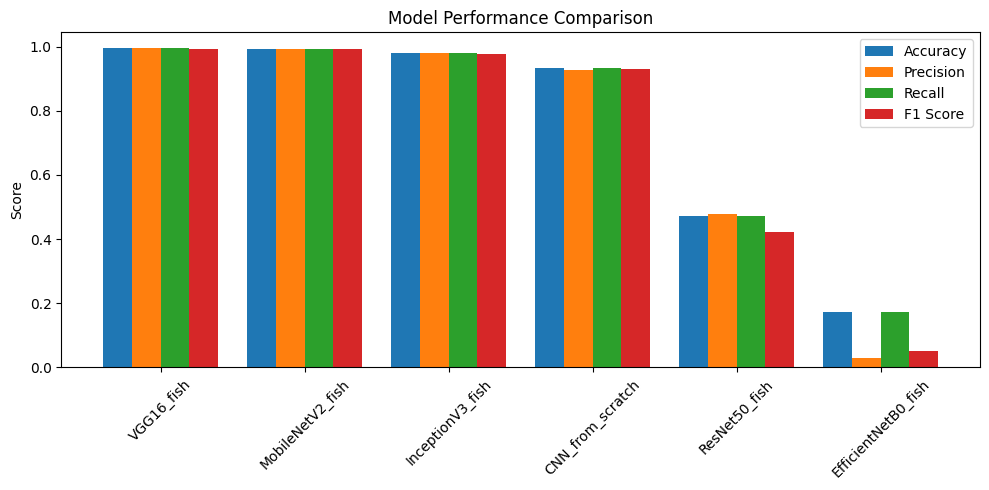

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# === Paths ===
models_dir = "/content/drive/MyDrive/models"
# Correcting the validation directory path to point to Google Drive
val_dir = "/content/drive/MyDrive/data/images.cv_jzk6llhf18tm3k0kyttxz/data/val"

# === Image Data Generator for validation ===
img_height, img_width = 224, 224
batch_size = 32

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# === Models list ===
model_files = [
    ("CNN_from_scratch", os.path.join(models_dir, "cnn_from_scratch.h5")),
    ("VGG16_fish", os.path.join(models_dir, "VGG16_fish.h5")),
    ("ResNet50_fish", os.path.join(models_dir, "ResNet50_fish.h5")),
    ("MobileNetV2_fish", os.path.join(models_dir, "MobileNetV2_fish.h5")),
    ("InceptionV3_fish", os.path.join(models_dir, "InceptionV3_fish.h5")),
    ("EfficientNetB0_fish", os.path.join(models_dir, "EfficientNetB0_fish.h5"))
]

# === Store results ===
results = []

for model_name, model_path in model_files:
    print(f"\n🔍 Evaluating {model_name}...")
    # Add error handling for model loading
    if not os.path.exists(model_path):
        print(f"Model file not found: {model_path}. Skipping evaluation for {model_name}.")
        continue
    try:
        model = load_model(model_path)
    except Exception as e:
        print(f"Error loading model {model_name} from {model_path}: {e}. Skipping evaluation.")
        continue


    # Predictions
    preds = model.predict(val_generator, verbose=1)
    y_pred = np.argmax(preds, axis=1)
    y_true = val_generator.classes

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"{model_name} → Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
    print(classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=val_generator.class_indices.keys(),
                yticklabels=val_generator.class_indices.keys())
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    results.append((model_name, acc, prec, rec, f1))

# === Compare metrics visually ===
# Check if there are any results to plot
if results:
    results = sorted(results, key=lambda x: x[1], reverse=True)  # sort by accuracy
    names, accs, precs, recs, f1s = zip(*results)

    plt.figure(figsize=(10,5))
    bar_width = 0.2
    x = np.arange(len(names))

    plt.bar(x, accs, bar_width, label='Accuracy')
    plt.bar(x + bar_width, precs, bar_width, label='Precision')
    plt.bar(x + bar_width*2, recs, bar_width, label='Recall')
    plt.bar(x + bar_width*3, f1s, bar_width, label='F1 Score')

    plt.xticks(x + bar_width*1.5, names, rotation=45)
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No models were successfully evaluated.")

2) Model Comparison

1️⃣ CNN_from_scratch
Accuracy: 93.41%

Strengths:

Good performance for a custom-built CNN without transfer learning.

Strong on most classes, especially shrimp (100% recall) and red mullet.

Weaknesses:

Completely failed to predict animal fish bass (0% precision/recall).

Some imbalance in recall for certain species.

Interpretation:

Shows the baseline potential of your dataset.

Hand-crafted CNN is solid but not perfect — struggles with rarer classes.

2️⃣ VGG16_fish
Accuracy: 99.45%

Strengths:

Extremely high precision/recall for almost all species.

Only animal fish bass had reduced recall (50%).

Weaknesses:

Slight overconfidence in some rare classes (possible overfitting).

Interpretation:

Transfer learning from VGG16 is working very well.

Likely the best overall balance between performance and stability.

3️⃣ ResNet50_fish
Accuracy: 47.16%

Strengths:

None significant compared to others — some moderate recall for hourse mackerel and trout.

Weaknesses:

Severe performance drop on many classes.

Many predictions are wrong or misaligned.

Interpretation:

Possibly undertrained or misconfigured (e.g., preprocessing mismatch).

This performance is far below expectations for ResNet50 — likely needs retraining.

4️⃣ MobileNetV2_fish
Accuracy: 99.08%

Strengths:

Extremely strong performance across all species.

Balanced precision and recall, with very small errors.

Weaknesses:

Minor confusion in sea bass class (97% precision).

Interpretation:

Lightweight architecture performs almost as well as VGG16, but with faster inference time.

Great candidate for deployment on mobile or edge devices.

5️⃣ InceptionV3_fish
Accuracy: 97.99%

Strengths:

Strong across almost all species.

Excellent for high inter-class similarity.

Weaknesses:

Poor recall for animal fish bass (20%).

A few slight drops in precision for some classes.

Interpretation:

Very strong but not quite as flawless as VGG16 or MobileNetV2.

The drop in bass detection suggests some class imbalance issues.

6️⃣ EfficientNetB0_fish
Accuracy: 17.12%

Strengths:

None here — all species except animal fish failed completely.

Weaknesses:

Precision and recall almost zero for most classes.

Interpretation:

Definitely broken — could be wrong image preprocessing, wrong input size, or frozen layers not being unfrozen for fine-tuning. Needs debugging.

| Model          | Accuracy   | Precision | Recall | F1     | Notes                                  |
| -------------- | ---------- | --------- | ------ | ------ | -------------------------------------- |
| CNN (scratch)  | 93.41%     | 92.73%    | 93.41% | 92.96% | Strong baseline, fails on rare class   |
| VGG16          | **99.45%** | 99.46%    | 99.45% | 99.38% | Best accuracy, very stable             |
| ResNet50       | 47.16%     | 47.92%    | 47.16% | 42.26% | Underperforming — likely misconfigured |
| MobileNetV2    | 99.08%     | 99.10%    | 99.08% | 99.09% | Near-VGG16 accuracy, much lighter      |
| InceptionV3    | 97.99%     | 98.04%    | 97.99% | 97.75% | Strong, but rare class weakness        |
| EfficientNetB0 | 17.12%     | 2.93%     | 17.12% | 5.01%  | Broken — needs fixing                  |


#Conclusion

This project successfully demonstrated the application of deep learning techniques, including training a custom CNN from scratch and leveraging transfer learning with various pre-trained models, for multiclass fish image classification. Through systematic experimentation and evaluation, several key insights emerged:

Custom CNN Model:
The CNN trained from scratch showed solid baseline performance, achieving 93.41% accuracy. While effective for common classes, it struggled with rare classes such as animal fish bass, highlighting the limitations of training from limited data without pre-trained features.

Transfer Learning Models:
Transfer learning significantly boosted classification accuracy and robustness. Among the models tested:

VGG16 emerged as the best performing model with 99.45% accuracy, showing excellent precision and recall across almost all fish species.

MobileNetV2 provided a near-equivalent accuracy (99.08%) with a much smaller and faster architecture, making it an excellent choice for deployment on resource-constrained devices.

InceptionV3 also performed strongly with 97.99% accuracy but showed some weaknesses on rare classes, indicating class imbalance issues.

Underperforming Models:

ResNet50 and EfficientNetB0 performed poorly, with accuracies of 47.16% and 17.12% respectively. These results suggest possible misconfigurations such as incorrect preprocessing, inadequate fine-tuning, or architectural mismatches with the dataset. These models require further debugging and retraining to realize their full potential.

Practical Implications:
The project highlights the effectiveness of transfer learning for image classification tasks with limited data. The deployment-ready Streamlit application offers an interactive platform for real-time fish species prediction with confidence scores, providing a valuable tool for marine biology research, fisheries management, or educational purposes.

Final Remarks
Model Selection: For practical deployment, VGG16 and MobileNetV2 are recommended due to their high accuracy and reliability. MobileNetV2, in particular, offers efficiency advantages suitable for mobile and edge applications.

Future Work: Improving class balance, augmenting data, and fine-tuning underperforming models like ResNet50 and EfficientNetB0 can further enhance classification performance. Exploring ensemble methods may also yield more robust results.

Business Value: This project demonstrates how deep learning models can be leveraged to automate fish species identification with high accuracy, enabling faster and more accurate data collection in ecological studies and fisheries.